## U shape PHP dynamics with multiple liquid slugs - with heat transfer

## $\frac{\partial \theta }{\partial \mathcal{T}} = \nabla^2 \theta$

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using DifferentialEquations

In [3]:
 using LinearAlgebra

In [4]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing

cd(dirname(pwd()))

In [5]:
function ifamongone(value::Float64, range::Tuple{Float64,Float64})
    return (value >= range[1]) && (value <= range[2]) ? true : false
end

ifamongone (generic function with 1 method)

In [6]:
function ifamong(value::Float64, X::Array{Tuple{Float64,Float64},1})
    
    return Bool(sum(ifamongone.(value,X)))
end

ifamong (generic function with 1 method)

In [7]:
function settemperature!(θᵣ,xvalue,sys0)
    
    if ifamong(xvalue, sys0.evaporator.Xe)
        θᵣ = sys0.evaporator.θe

    elseif ifamong(xvalue, sys0.condenser.Xc)
        θᵣ = sys0.condenser.θc
    end

    return θᵣ
    
end

settemperature! (generic function with 1 method)

In [8]:
function laplacian(u)
    unew = deepcopy(u)
    
    dl = ones(length(u)-1)
    dr = dl
    d  = -2*ones(length(u))
    
    A = Tridiagonal(dl, d, dr)
    
    unew = A*u
    
    unew[1]   = unew[2]
    unew[end] = unew[end-1]
    
    return (unew)
end

laplacian (generic function with 1 method)

In [9]:
function constructXarrays(X0::Array{Tuple{Float64,Float64},1},N,θinitial)
    Xarrays=Array{Array{Float64, 1}, 1}(undef, length(X0)) 

    Lliquid = XptoLliquidslug(X0)

    Nliquid =  floor.(Int, N.*Lliquid./L)

    for i = 1:length(Xarrays)
        Xarrays[i] = range(X0[i][1], X0[i][2], length=Nliquid[i])
    end

    θarrays = deepcopy(Xarrays)
    for i = 1:length(θarrays)
        θarrays[i][:] .= θinitial
    end
    
    return(Xarrays,θarrays)
end

constructXarrays (generic function with 1 method)

In [10]:
function constructXarrays(L::Float64,N,θinitial)
    Xwallarray = Array{Float64, 1}(undef, N) 
    Xwallarray = range(0, L, length=N)

    θwallarray = deepcopy(Xwallarray)
    θwallarray = range(θinitial, θinitial, length=N)
    
    return(Xwallarray,θwallarray)
end

constructXarrays (generic function with 2 methods)

## Parameters of the PHP

In [11]:
    ω0 = [sqrt(1.2e004), sqrt(1.2e004)];
    ℘ = [1.2e005, 1.2e005];

    θinitial=1.0
    θ  = 0.15;
    θe = 1 + θ;
    θc = 1 - θ;
    
    He = 3000.0;
    Hc = 3000.0;
    
    X0 = 0.5;

    γ = 1.4;

In [12]:
    L = 8.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    angle = pi/2 # inclination angle 


1.5707963267948966

## Pipe definition

In [13]:
tube = Tube(L,L2D,angle)

Tube(8.0, 2.0, 1.5707963267948966)

## Evaporator and condenser definition

In [14]:
Xe = map(tuple, [0.0; 3.0; 7.0], [1.0; 5.0; 8.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)])

In [15]:
Xc = map(tuple, [1.0; 5.0], [3.0; 7.0])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)])

## Vapor plug and liquid slug initialization

In [16]:
N=1000
X0 = [(0.5,2.5),(5.0,7.0)]
dXdt0 = [(0.0,0.0),(0.0,0.0)]
Xarrays,θarrays = constructXarrays(X0,N,θinitial)
liquids=Liquid(γ,ω0,℘,X0,dXdt0,Xarrays,θarrays)

Liquid(1.4, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5], [5.0, 5.008032128514056, 5.016064257028113, 5.024096385542169, 5.032128514056225, 5.040160642570281, 5.048192771084337, 5.056224899598393, 5.06425702811245, 5.072289156626506  …  6.927710843373494, 6.93574297188755, 6.943775100401607, 6.951807228915663, 6.959839357429719, 6.967871485943775, 6.975903614457831, 6.983935742971887, 6.991967871485944, 7.0]], Array{Float64,1}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0

In [17]:
P = [1.0,1.0,1.0];
vapors=Vapor(γ,P)

Vapor(1.4, [1.0, 1.0, 1.0])

In [62]:
α = 1 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)
Xwallarray,θwallarray = constructXarrays(L,N,θinitial)

wall = Wall(α,Xwallarray,θwallarray)

Wall(1.0, [0.0, 0.008008008008008008, 0.016016016016016016, 0.024024024024024024, 0.03203203203203203, 0.04004004004004004, 0.04804804804804805, 0.056056056056056056, 0.06406406406406406, 0.07207207207207207  …  7.927927927927928, 7.935935935935936, 7.943943943943944, 7.951951951951952, 7.95995995995996, 7.967967967967968, 7.975975975975976, 7.983983983983984, 7.991991991991992, 8.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

## Construct the system

In [63]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors,wall)

PHPSystem(Tube(8.0, 2.0, 1.5707963267948966), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 1.0), (3.0, 5.0), (7.0, 8.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.0, 3.0), (5.0, 7.0)]), Liquid(1.4, [109.54451150103323, 109.54451150103323], [120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0)], Array{Float64,1}[[0.5, 0.5080321285140562, 0.5160642570281124, 0.5240963855421686, 0.5321285140562249, 0.5401606425702812, 0.5481927710843374, 0.5562248995983936, 0.5642570281124498, 0.572289156626506  …  2.427710843373494, 2.4357429718875503, 2.4437751004016066, 2.4518072289156625, 2.459839357429719, 2.467871485943775, 2.4759036144578315, 2.4839357429718874, 2.4919678714859437, 2.5], [5.0, 5.008032128514056, 5.016064257028113, 5.024096385542169, 5.032128514056225, 5.040160642570281, 5.048192771084337, 5.056224899598393, 5.06425702811245, 5.072289156626506  …  6.927710843373494, 6.93574297188755, 6.943775100401607, 

In [64]:
typeof(sys0)

PHPSystem

## Construct U for wall heat function

In [65]:
x = range(0.0, sys0.tube.L, length=N)
θᵣ = range(θinitial, θinitial, length=N)
θᵣ = settemperature!.(θᵣ,x,[sys0])

1000-element Array{Float64,1}:
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 ⋮   
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15
 1.15

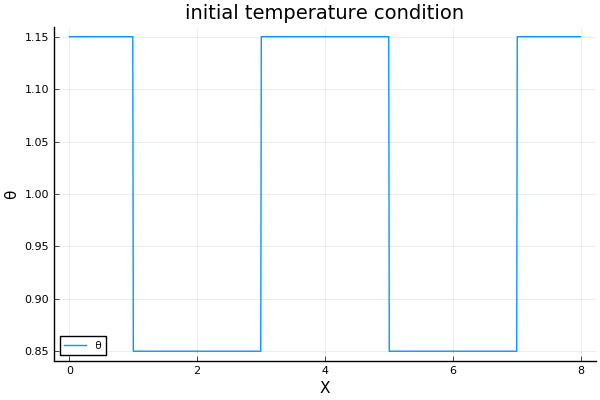

In [66]:
plot([x],[θᵣ], title="initial temperature condition", labels = "θ", xlabel="X", ylabel="θ")

## Solve the constructed ODE for U

### propagation function

In [67]:
function dfdt(u,p,t)
    
 α = p.wall.α
 dx = p.wall.Xarray[2]-p.wall.Xarray[1]
    
 du = α*laplacian(u)/dx/dx
    
    du
end


dfdt (generic function with 1 method)

### condition

In [68]:
function condition(u,t,integrator)
    false
end

condition (generic function with 1 method)

### affect! (with boundary conditions)

In [69]:
function affect!(integrator)
    θᵣtemp = deepcopy(integrator.u)
    
    θᵣtemp = settemperature!.(θᵣtemp,x,[sys0])
    
    set_u!(integrator,  θᵣtemp)
end

affect! (generic function with 1 method)

In [70]:
cb = DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, Bool[1, 1])

In [71]:
tstep=1e-5

p = sys0
tspan = (0.0, 0.1);
prob = ODEProblem(dfdt, θᵣ, tspan, p)

# integrator = init(prob, RK4(), adaptive=false, dt=tstep, );
sol = solve(prob, RK4(), adaptive=false, dt=tstep, callback=cb, save_everystep=true);

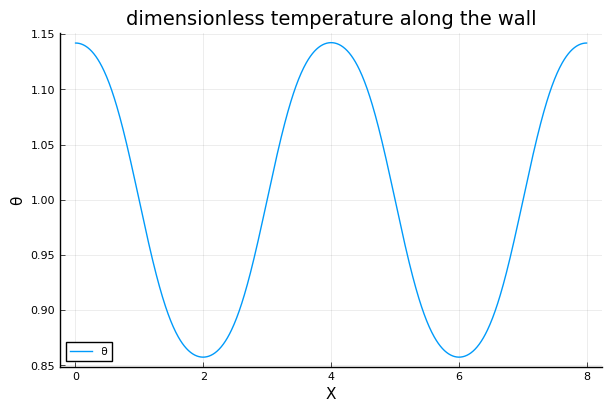

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\OneDThermalFlow\tmp.gif
└ @ Plots C:\Users\liyux\.juliapro\JuliaPro_v1.3.1-2\packages\Plots\ninUP\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\OneDThermalFlow\\tmp.gif")
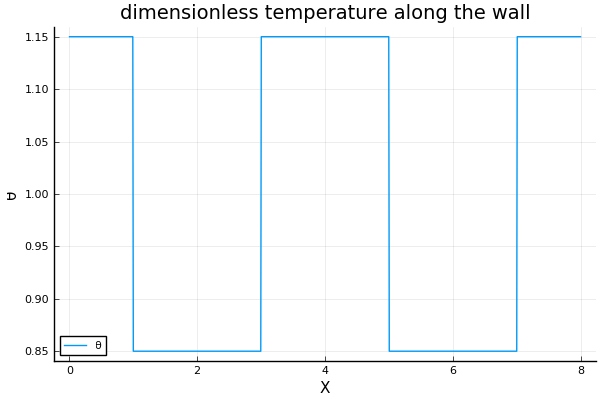

In [73]:
@gif for i=1:size(sol,2)
plot([x],[sol[i]], labels = "θ", xlabel="X", ylabel="θ", title=("dimensionless temperature along the wall"))
    end every 100